In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3

#### compare PASEF features that were identified and see whether 3DID also detected them

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

IDENTS_PASEF_DIR = '{}/P3856-results-cs-false-fmdw-true-2021-04-28-22-33-56/identifications-pasef'.format(expanduser("~"))
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]


In [5]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [6]:
print('{} identified features from PASEF, {} features from 3DID'.format(len(idents_pasef_df), len(features_3did_df)))

8827 identified features from PASEF, 21888 features from 3DID


In [7]:
idents_pasef_df.charge.value_counts()

2    6954
3    1436
4     324
5      62
1      46
6       5
Name: charge, dtype: int64

In [8]:
features_3did_df.charge.value_counts()

2    17718
3     2266
1      968
4      619
5      191
6       86
8       25
7       15
Name: charge, dtype: int64

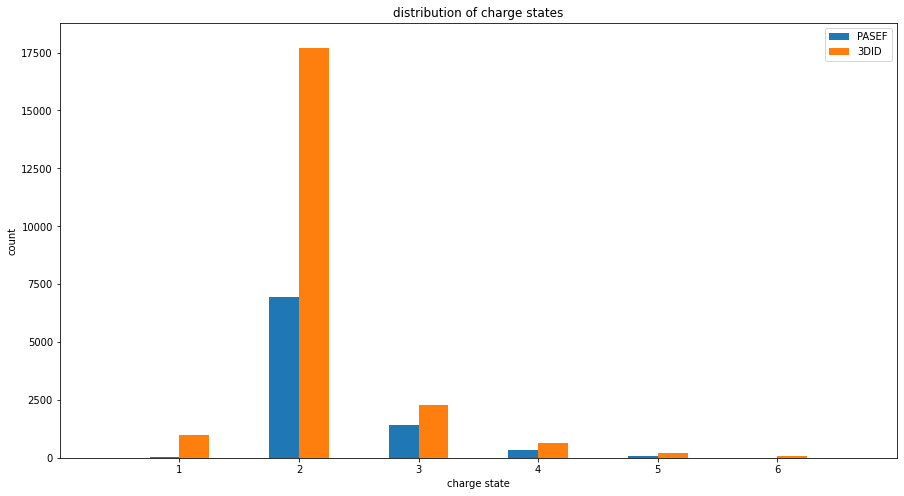

In [9]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.25

pos1 = [x - barwidth/2 for x in range(max(idents_pasef_df.charge.max(), features_3did_df.charge.max())+1)]
pos2 = [x + barwidth for x in pos1]

counts = np.bincount(idents_pasef_df.charge, minlength=9)
ax1.bar(pos1, counts, width=barwidth, align='center', label='PASEF')

counts = np.bincount(features_3did_df.charge, minlength=9)
ax1.bar(pos2, counts, width=barwidth, align='center', label='3DID')

ax1.set(xticks=range(1,idents_pasef_df.charge.max()+1), xlim=[0, idents_pasef_df.charge.max()+1])

plt.xlabel('charge state')
plt.ylabel('count')
plt.title('distribution of charge states')

plt.legend()
plt.show()

#### find the features in common

In [10]:
DUP_MZ_TOLERANCE_PPM = 5
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 10

In [11]:
# set up dup definitions for 3DID
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_3did_df['dup_mz'] = features_3did_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_3did_df['dup_mz_ppm_tolerance'] = features_3did_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['dup_mz_lower'] = features_3did_df.dup_mz - features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_mz_upper'] = features_3did_df.dup_mz + features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_scan_lower'] = features_3did_df.scan_apex - DUP_SCAN_TOLERANCE
features_3did_df['dup_scan_upper'] = features_3did_df.scan_apex + DUP_SCAN_TOLERANCE
features_3did_df['dup_rt_lower'] = features_3did_df.rt_apex - DUP_RT_TOLERANCE
features_3did_df['dup_rt_upper'] = features_3did_df.rt_apex + DUP_RT_TOLERANCE

In [12]:
# set up dup definitions for PASEF
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
idents_pasef_df['dup_mz'] = idents_pasef_df['monoisotopic_mz']  # shorthand to reduce verbosity
idents_pasef_df['dup_mz_ppm_tolerance'] = idents_pasef_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
idents_pasef_df['dup_mz_lower'] = idents_pasef_df.dup_mz - idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_mz_upper'] = idents_pasef_df.dup_mz + idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_scan_lower'] = idents_pasef_df.scan_apex - DUP_SCAN_TOLERANCE
idents_pasef_df['dup_scan_upper'] = idents_pasef_df.scan_apex + DUP_SCAN_TOLERANCE
idents_pasef_df['dup_rt_lower'] = idents_pasef_df.rt_apex - DUP_RT_TOLERANCE
idents_pasef_df['dup_rt_upper'] = idents_pasef_df.rt_apex + DUP_RT_TOLERANCE

In [13]:
idents_pasef_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)
features_3did_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)

In [14]:
# find whether a feature detected by PASEF was also detected by 3DID
common_l = []
for row in idents_pasef_df.itertuples():
#     df = features_3did_df[(row.charge == features_3did_df.charge) & (row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
    df = features_3did_df[(row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
    if len(df) > 0:
        common_l.append(
            {
                'feature_id_pasef':row.feature_id, 
                'deconv_score_pasef':row.deconvolution_score,
                'feature_intensity_pasef':row.feature_intensity,
                'feature_id_3did':df.iloc[0].feature_id, 
                'deconv_score_3did':df.iloc[0].deconvolution_score,
                'feature_intensity_3did':df.iloc[0].feature_intensity
            }
        )
common_df = pd.DataFrame(common_l)

In [15]:
print('{} features in common'.format(len(common_df)))

4456 features in common


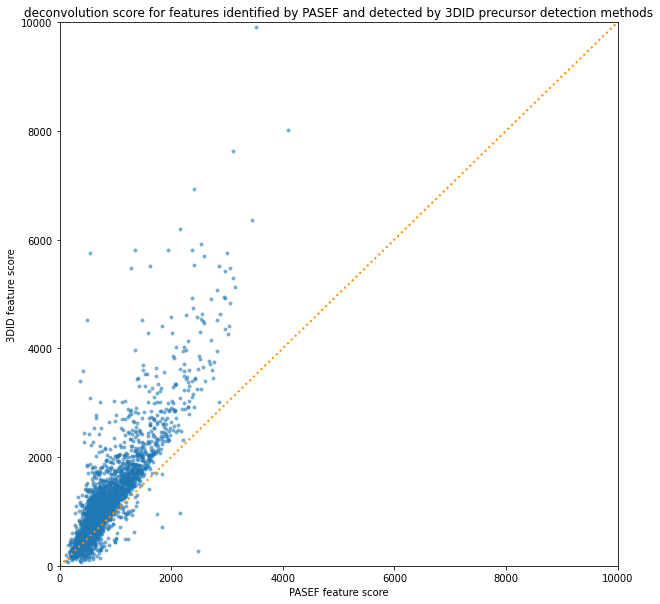

In [16]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('deconvolution score for features identified by PASEF and detected by 3DID precursor detection methods')

ax.scatter(common_df.deconv_score_pasef, common_df.deconv_score_3did, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,10000))
plt.ylim((-1,10000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

#### visualise a feature detected by PASEF but not by 3DID

In [17]:
# find the PASEF feature IDs that are not in the common set
feature_ids_not_found_by_3did_l = list(set(idents_pasef_df.feature_id.to_list()) - set(common_df.feature_id_pasef.to_list()))


In [18]:
import random

pasef_feature_not_detected = random.choice(feature_ids_not_found_by_3did_l)
pasef_feature_not_detected

2850902

In [19]:
selected_feature = idents_pasef_df[(idents_pasef_df.feature_id == pasef_feature_not_detected)].iloc[0]
selected_feature

mono_mz_lower                                                                             846.897
mono_mz_upper                                                                             846.951
scan_apex                                                                                     447
scan_lower                                                                                    414
scan_upper                                                                                    489
rt_apex                                                                                   1957.42
rt_lower                                                                                  1953.19
rt_upper                                                                                  1963.77
mono_intensity_without_saturation_correction                                                77789
mono_intensity_with_saturation_correction                                                   77789
mono_intensity_adjus

#### find the most intense raw point in this feature's envelope

In [25]:
envelope = json.loads(selected_feature.envelope)

In [26]:
mz_lower = envelope[0][0]
mz_upper = envelope[-1][0]
scan_lower = selected_feature.scan_lower
scan_upper = selected_feature.scan_upper
rt_lower = selected_feature.rt_lower
rt_upper = selected_feature.rt_upper

In [23]:
CONVERTED_DATABASE_NAME = '/media/big-ssd/experiments/P3856/converted-databases/exp-P3856-run-{}-converted.sqlite'.format(run_name)

In [29]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select * from frames where frame_type == 0 and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {};".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper), db_conn)
db_conn.close()

In [30]:
raw_df.intensity.max()

393

#### plot the intensities of features identified by PASEF but not detected by 3DID

In [37]:
intensities_not_detected_3did_df = intensities_df[(intensities_df.not_detected_3did == True)]

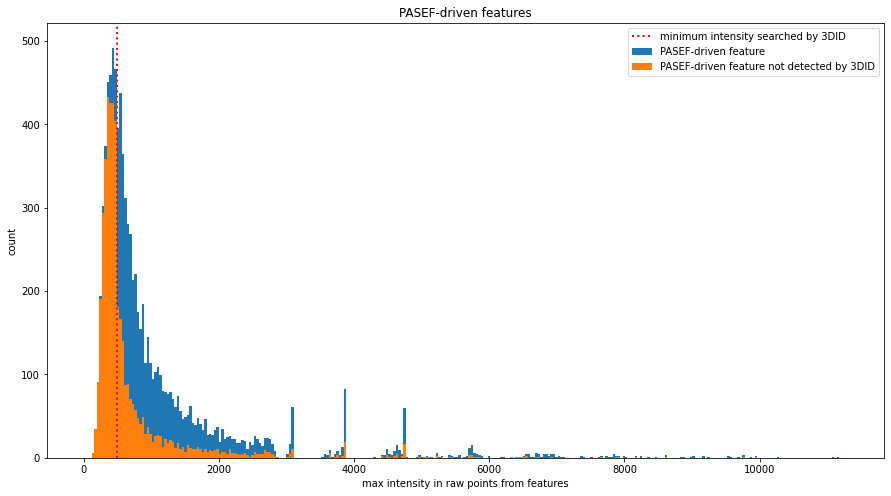

In [41]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('PASEF-driven features')

bins = 300
hist, bins, _ = plt.hist(intensities_df.max_intensity, bins=bins, label='PASEF-driven feature')
hist, bins, _ = plt.hist(intensities_not_detected_3did_df.max_intensity, bins=bins, label='PASEF-driven feature not detected by 3DID')

plt.xlabel('max intensity in raw points from features')
plt.ylabel('count')

plt.axvline(x=500, linestyle=':', color='red', linewidth=2, label='minimum intensity searched by 3DID')

# plt.xlim((-20,20))
# plt.ylim((0,300))

plt.legend()
plt.show()